In [312]:
# For making a spider plot (not radar, to avoid confusion).
# Adapted from: https://datascience.stackexchange.com/questions/6084/how-do-i-create-a-complex-radar-chart

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd

def prep_spider(means,ranges,offsets):

    label_ranges = {}
    for key, values in ranges.iteritems():
        #ZDR and DBZH should be the only values with negative values in their ranges.
        
        label_ranges[key] = values
        if key == 'ZDR':
            
            ranges[key] = [x + offsets['ZDR'] for x in values]
            values = ranges[key]

        elif key == 'DBZH': 
        
            ranges[key] = [x + offsets['DBZH'] for x in values]
            values = ranges[key]
            
        # The radial grid won't accept non-positive numbers, so we also need to 
        # add a pertubation to where 0 is the lower end on of the range

        if values[0] == 0.:
            ranges[key] = [x + offsets['zero'] for x in values]
    
    means_offset = means
    means_offset['ZDR'] = means['ZDR'] + offsets['ZDR']
    means_offset['DBZH'] = means['DBZH'] + offsets['DBZH']
    means_offset['KDP'] = means['KDP'] + offsets['zero']
    
    return means_offset, ranges, label_ranges

def _invert(x, limits):
    """inverts a value x on a scale from
    limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])

def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        try:
            assert (y1 <= d <= y2) or (y2 <= d <= y1)
        except Exception as e:
            print('Value ' + str(d) + ' is  out of range ' + str(y1) + ' ' + str(y2))
            print(e)
    x1, x2 = ranges[0]
    d = data[0]
    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1
    sdata = [d]
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1
        sdata.append((d-y1) / (y2-y1) 
                     * (x2 - x1) + x1)
    return sdata

class ComplexSpider():
    def __init__(self, fig, variables, ranges,label_ranges,
                 n_ordinate_levels=6):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=variables)
        [txt.set_rotation(angle-90) for txt, angle 
             in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
        for i, ax in enumerate(axes):
            
            grid = np.linspace(*ranges[i], 
                               num=n_ordinate_levels)
            
            grid_for_labels = np.linspace(*label_ranges[i], 
                               num=n_ordinate_levels)
            
            gridlabel = ["{}".format(round(x,1)) 
                         for x in grid_for_labels]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

In [6]:
import pickle
import pandas as pd

In [7]:
df = pd.read_hdf('./training_data/Mt_Bolton_height_185.h5')


In [313]:
ranges = {'DBZH':[0.,50],
        'ZDR':[-3,2],
        'RHOHV':[0.,1.],
        'WRADH':[0.,2.8],
        'KDP':[0.,1.],
        'ALT':[0.,5000.]}
offsets = {'DBZH':0.,
        'ZDR':7.,
        'zero':1e-6}

In [314]:
models_fn = './models/Mt_Bolton_altitude_4_12.gmm'

#Load and sort models
models = pickle.load(open(models_fn, 'rb'))
models = sorted(models, key=lambda k: k.n_components)

#Select model
mod_no = 7

#Extract means from model
means = pd.DataFrame(models[mod_no].means_.copy(),columns=list(df))

In [315]:
#models_fn = './models/Mt_Bolton_altitude_185_4_12.gmm'
models_fn = './models/Mt_Bolton_altitude_4_12.gmm'

#Load and sort models
models = pickle.load(open(models_fn, 'rb'))
models = sorted(models, key=lambda k: k.n_components)

#Select model
mod_no = 7

#Extract means from model
means = pd.DataFrame(models[mod_no].means_.copy(),columns=list(df))
k = models[mod_no].n_components

#Generate discrete cmap
dcmap = discrete_cmap(k,'pyart_NWSRef')
 
#Implement plotting offsets
means_offset, ranges_offset, label_ranges = prep_spider(means,ranges,offsets)

In [316]:
label_ranges

{'ALT': [0.0, 5000.0],
 'DBZH': [0.0, 50],
 'KDP': [0.0, 1.0],
 'RHOHV': [0.0, 1.0],
 'WRADH': [0.0, 2.8],
 'ZDR': [-3, 2]}

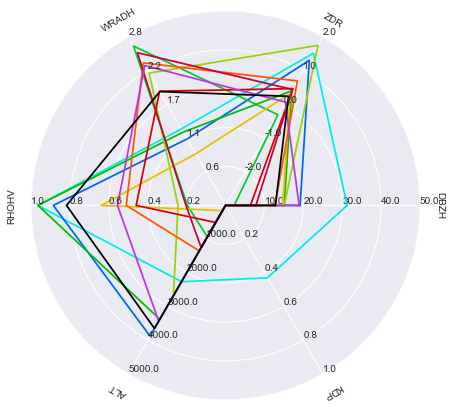

In [317]:
fig1 = plt.figure(figsize=(6, 6))
radar = ComplexSpider(fig1,
                     [key for key in ranges_offset.iterkeys()],
                     [val for val in ranges_offset.itervalues()],
                     [val for val in label_ranges.itervalues()])

for n in range(len(means_offset)):
    radar.plot([means_offset[val][n] for val in ranges_offset.iterkeys()],color=dcmap(n))
plt.show()

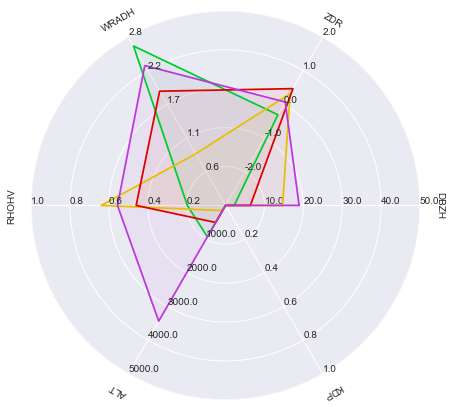

In [318]:
fig2 = plt.figure(figsize=(6, 6))
radar = ComplexSpider(fig2,
                     [key for key in ranges_offset.iterkeys()],
                     [val for val in ranges_offset.itervalues()],
                     [val for val in label_ranges.itervalues()])

for n in [2,5,7,9]:
    radar.plot([means_offset[val][n] for val in ranges_offset.iterkeys()],color=dcmap(n))
    radar.fill([means_offset[val][n] for val in ranges_offset.iterkeys()],color=dcmap(n),alpha=0.05)
plt.show()

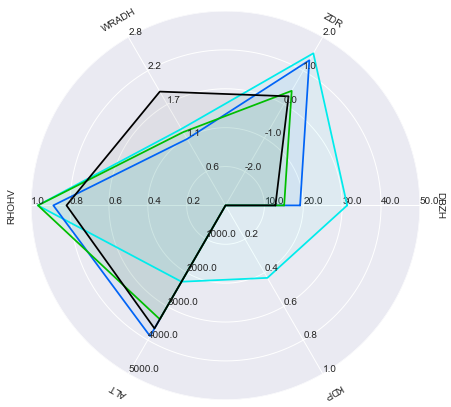

In [320]:
fig3 = plt.figure(figsize=(6, 6))
radar = ComplexSpider(fig3,
                     [key for key in ranges_offset.iterkeys()],
                     [val for val in ranges_offset.itervalues()],
                     [val for val in label_ranges.itervalues()])

for n in [0,1,3,10]:
    radar.plot([means_offset[val][n] for val in ranges_offset.iterkeys()],color=dcmap(n))
    radar.fill([means_offset[val][n] for val in ranges_offset.iterkeys()],color=dcmap(n),alpha=0.05)
plt.show()

# Universal Colorbar for Plots

In [199]:
def discrete_cmap(N, base_cmap=None):
    import matplotlib.pyplot as plt
    import pyart
    """Create an N-bin discrete colormap from the specified input map"""

    #Source: https://gist.github.com/jakevdp/91077b0cae40f8f8244a 
    
    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [207]:
discrete_cmap(7,'pyart_NWSRef')([0])

array([[ 0.       ,  0.9254902,  0.9254902,  1.       ]])

In [210]:
models[0]

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=12, n_init=1, precisions_init=None,
        random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [34]:
[val for val in ranges.itervalues()]

[(0, 50), (-7, 7), (0, 3.5), (0, 1), (0, 10000), (0, 2.23)]

In [42]:
[val for val in ranges.itervalues()]

[(0, 50), (0, 14), (0, 3.5), (0, 1), (0, 10000), (0, 2.23)]

In [89]:
plt.clf()

In [63]:
round(3.32,0)

3.0

In [68]:
means['ZDR'] = means['ZDR']+7

0     7.685722
1     7.429270
2     7.087531
3     6.622835
4     7.201841
5     9.054194
6     7.121297
7     7.730615
8     8.492324
9     8.666279
10    7.245694
11    7.517221
Name: ZDR, dtype: float64

In [71]:
[means[val][0] for val in ranges.iterkeys()]

[18.042686906905555,
 0.68572190172458924,
 2.3435482358654354,
 0.47256229249538967,
 2089.5887696469904,
 0.0]

In [77]:
1e-6

0.01

# Old Spider Plots

In [ ]:
means = pd.DataFrame(models[0].means_,columns=list(df))
means['cluster_no'] = range(1,len(means)+1)

In [ ]:

def make_spider(df, row, title, color):

    from math import pi
    # number of variable
    categories=list(df)[:-1]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(4,3,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    #plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
    plt.ylim(0,1.2)
    
    #labels = 
    
    #for ax, angle, label in zip(self.axes, self.angles, labels):
    #    ax.set_rgrids(range(1, 7), labels=label, angle=angle, fontsize=12)
    #    ax.spines["polar"].set_visible(False)
    #    ax.set_ylim(0, 6)  

    # Ind1
    values=df.loc[row].drop('cluster_no').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=11, color=color, y=1,x=0,loc='left')

def scale_moments(df,label=False):
    ranges = {}

    ranges['DBZH'] = [0,50]
    ranges['ZDR'] = [-7,7]
    ranges['RHOHV'] = [0,1]
    ranges['WRADH'] = [0,3.5]
    ranges['KDP'] = [0,2.23]
    ranges['ALT'] = [0,10000]

    scalers = {}
    
    if label:
        labels = {}
        for key, values in ranges.iteritems():
            df[key] = df[key] * (values[1]-values[0]) + values[0]
            labels[]
            np.linspace(0,1,5)
            
    else:
        for key, values in ranges.iteritems():
            df[key] = (df[key]-values[0])/(values[1]-values[0])
        
        return df

def scale_moments(n,df,inverse=False):
    ranges = {}

    ranges['DBZH'] = [0,50]
    ranges['ZDR'] = [-7,7]
    ranges['RHOHV'] = [0,1]
    ranges['WRADH'] = [0,3.5]
    ranges['KDP'] = [0,2.23]
    ranges['ALT'] = [0,10000]

    scalers = {}
    
    if inverse:
        for key, values in ranges.iteritems():
            df[key] = df[key] * (values[1]-values[0]) + values[0]
    else:
        for key, values in ranges.iteritems():
            df[key] = (df[key]-values[0])/(values[1]-values[0])
        
    return df

In [ ]:
means = pd.DataFrame(models[6].means_.copy(),columns=list(df))
means['cluster_no'] = range(1,len(means)+1)

means.iloc[:,:-1] = scale_moments(means.iloc[:,:-1])

my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(means.index))

# Loop to plot
for row in range(0, len(means.index)):
    make_spider(df=means, row=row, title='Cluster '+str(means['cluster_no'][row]), color=my_palette(row))

In [ ]:
class Spider(object):

    def __init__(self, fig, titles, labels, rect=None):
        if rect is None:
            rect = [0.05, 0.05, 0.95, 0.95]

        self.n = len(titles)
        self.angles = np.arange(90, 90+360, 360.0/self.n)
        self.axes = [fig.add_axes(rect, projection="polar", label="axes%d" % i) 
                         for i in range(self.n)]

        self.ax = self.axes[0]
        self.ax.set_thetagrids(self.angles, labels=titles, fontsize=14)

        for ax in self.axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)

        for ax, angle, label in zip(self.axes, self.angles, labels):
            ax.set_rgrids(range(1, 6), angle=angle, labels=label)
            ax.spines["polar"].set_visible(False)
            ax.set_ylim(0, 5)

    def plot(self, values, *args, **kw):
        angle = np.deg2rad(np.r_[self.angles, self.angles[0]])
        values = np.r_[values, values[0]]
        self.ax.plot(angle, values, *args, **kw)



fig = plt.figure(figsize=(6, 6))

titles = list(means)

labels = [
    list("abcde"), list("12345"), list("uvwxy"), 
    ["one", "two", "three", "four", "five"],
    list("jklmn")
]

radar = Spider(fig, titles, labels)
radar.plot([1, 3, 2, 5, 4],  "-", lw=2, color="b", alpha=0.4, label="first")
radar.plot([2.3, 2, 3, 3, 2],"-", lw=2, color="r", alpha=0.4, label="second")
radar.plot([3, 4, 3, 4, 2], "-", lw=2, color="g", alpha=0.4, label="third")
radar.ax.legend()